# Get Image

In [1]:
import urllib
from PIL import Image

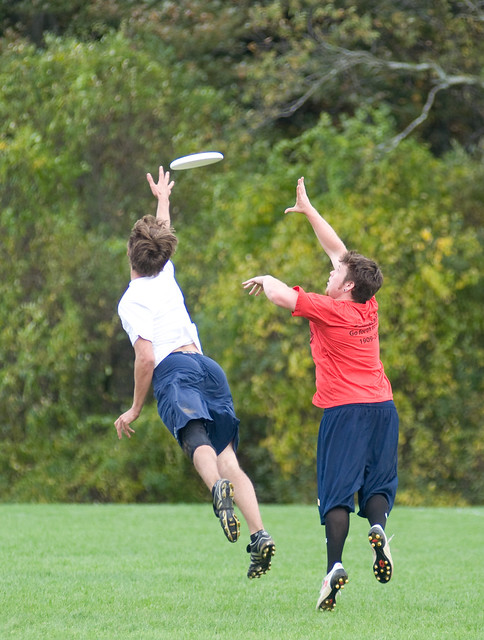

In [2]:
# Grab image from: http://cocodataset.org/
image_url = 'http://farm4.staticflickr.com/3499/4007229890_859439ab03_z.jpg'
img_response = urllib.request.urlopen(image_url)
img = Image.open(img_response)
img

# Convert image to tensor

In [3]:
from torchvision.transforms import ToTensor, ToPILImage

In [4]:
img_tensor = ToTensor()(img)
print("SHAPE:", img_tensor.shape)
print("DATA TYPE:", img_tensor.dtype)

SHAPE: torch.Size([3, 640, 484])
DATA TYPE: torch.float32


# Model

In [5]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [6]:
model = maskrcnn_resnet50_fpn(pretrained=True)

# Input tensor

### Documentation: 
https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn

```
The input to the model is expected to be a list of tensors, 
each of shape [C, H, W], one for each image, and should be in 0-1 range. 
```

In [7]:
import torch

In [8]:
torch.min(img_tensor), torch.max(img_tensor)

(tensor(0.), tensor(1.))

In [9]:
img_tensor.shape

torch.Size([3, 640, 484])

In [10]:
imgs_tensor = img_tensor.unsqueeze(0)
imgs_tensor.shape

torch.Size([1, 3, 640, 484])

# Inference

In [11]:
model.eval()
pass

In [12]:
outputs = model(imgs_tensor)

In [13]:
output = outputs[0]

In [14]:
output.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [15]:
masks = output['masks']
labels = output['labels']
scores = output['scores']

# Process masks

> Indented block



In [16]:
masks.shape

torch.Size([6, 1, 640, 484])

In [17]:
labels

tensor([34,  1,  1,  1, 40, 40])

In [18]:
scores

tensor([0.9997, 0.9994, 0.9984, 0.1417, 0.0906, 0.0565],
       grad_fn=<IndexBackward>)

**Text Labels:**   
https://github.com/nightrome/cocostuff#labels  
https://github.com/nightrome/cocostuff/blob/master/labels.md   

NMS (if needed):  
nms_result = torchvision.ops.nms(boxes, scores, nms_threshold)

In [19]:
# Get masks of people
person_masks = []
person_label = 1
score_threshold = 0.7

for index, label in enumerate(labels):
    if label == person_label and scores[index] > score_threshold:
        person_masks.append(masks[index])

len(person_masks)

2

In [20]:
# Calculate global mask
global_mask = torch.zeros_like(person_masks[0])
mask_threshold = 0.1

for mask in person_masks:
    global_mask = global_mask + (mask>mask_threshold)

global_mask = (global_mask>0).float()
global_mask.shape, global_mask.dtype

(torch.Size([1, 640, 484]), torch.float32)

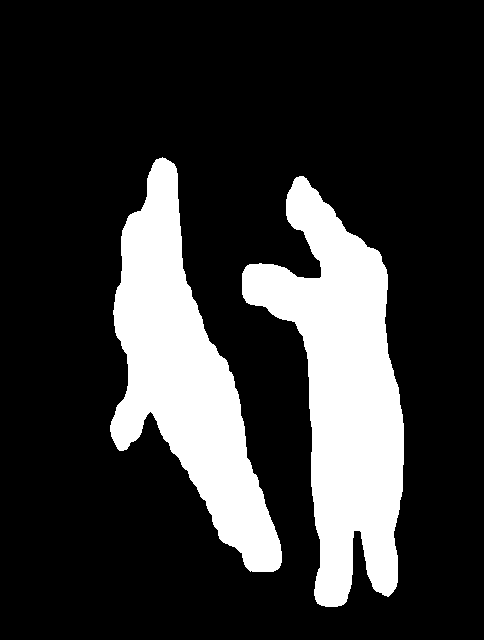

In [21]:
# Convert mask to PIL image
mask_img = ToPILImage()(global_mask)
mask_img = mask_img.convert('RGB')
mask_img

# Apply mask

In [22]:
import numpy as np

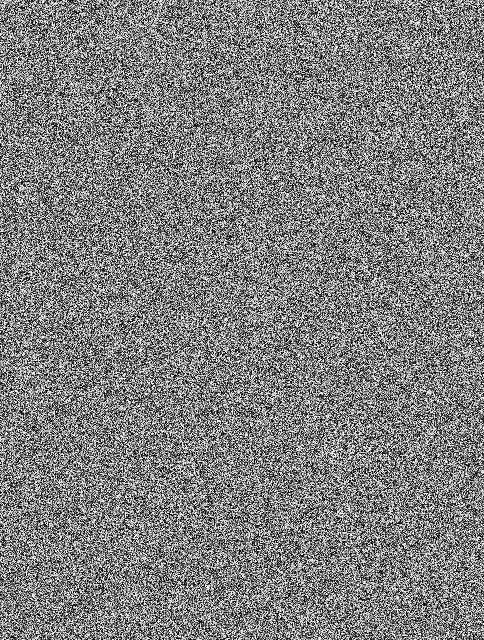

In [23]:
# Let's generate some noise!
img_noise = (np.random.rand(mask_img.size[1], img.size[0],1 )*255).astype('uint8')
Image.fromarray(img_noise[:,:,0])

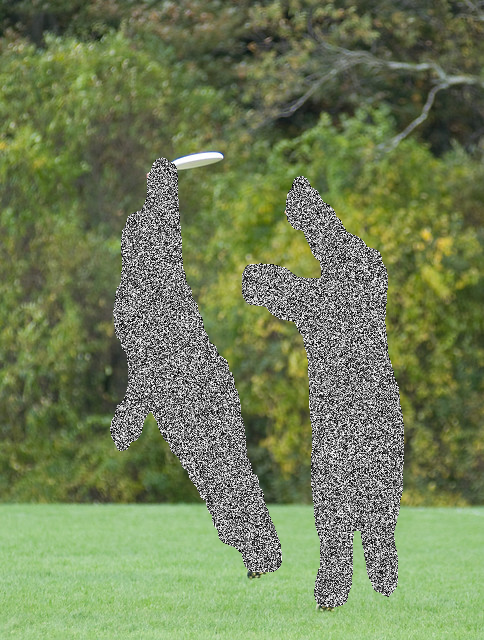

In [24]:
# Mix image wth noise depending on mask
img_orig = np.array(img)
img_mask = np.array(mask_img)

img_final = (img_mask == 255) * img_noise + (img_mask!=255) * img_orig
img_final = Image.fromarray(img_final)
img_final

# Extra (Blur background)

In [25]:
import cv2

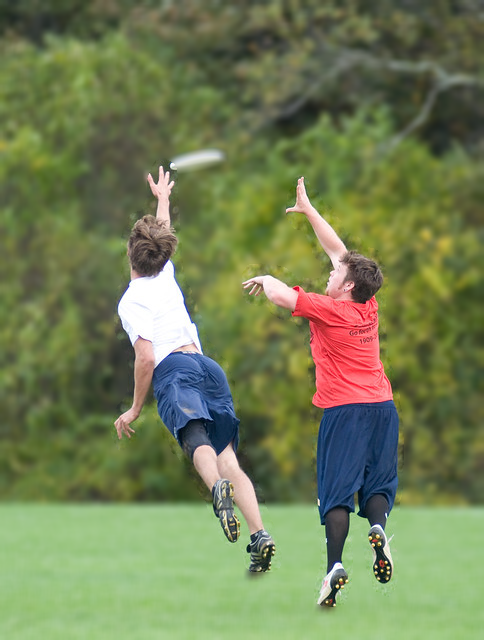

In [36]:
# Mix image wth noise depending on mask
img_orig = np.array(img)
img_mask = np.array(mask_img)
img_blur = cv2.blur(img_orig, (9,9))

img_final = (img_mask == 255) * img_orig + (img_mask!=255) * img_blur
img_final = Image.fromarray(img_final)
img_final

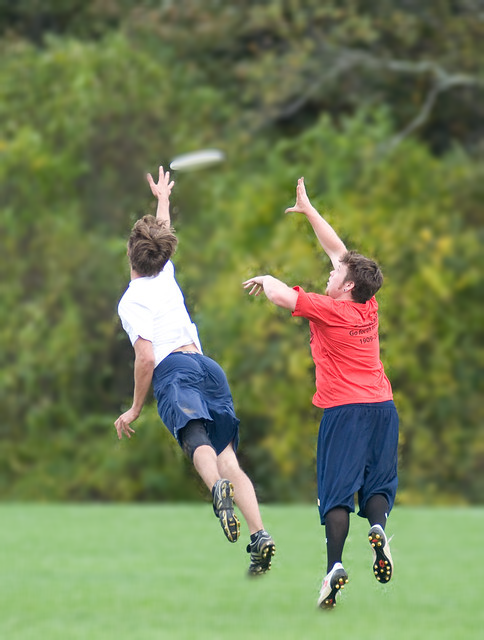

In [37]:
# Mix image with noise depending on mask
img_orig = np.array(img)
img_mask = np.array(mask_img)
img_mask = cv2.blur(img_mask, (9,9))
img_blur = cv2.blur(img_orig, (9,9))

img_final = ((img_mask/255) * img_orig + (1-img_mask/255) * img_blur).astype('uint8')
img_final = Image.fromarray(img_final)
img_final